# BHARTIARTL Stock Return Prediction — Complete ML Pipeline

**Course: DA6701 — Data Science & AI for Finance**

---

## Objective

Predict the **next-day log return** for BHARTIARTL using:
- **XGBoost** (baseline)
- **LightGBM** (bonus comparison)
- **LSTM** (deep learning)

Uses strict **walk-forward (expanding window) validation** and generates **Oct–Dec 2025 forward predictions** for portfolio construction.


In [1]:
# Install required packages (run once)
import subprocess, sys

PACKAGES = ['xgboost', 'lightgbm', 'torch', 'scikit-learn', 'matplotlib', 'seaborn', 'pandas', 'numpy']
for pkg in PACKAGES:
    try:
        __import__(pkg.replace('-', '_'))
    except ImportError:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg, '-q'])
print("All packages available.")

All packages available.


In [2]:
# ============================================================
# IMPORTS
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import warnings
import os
import random
import json
import pickle
from pathlib import Path

# ML
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

# Deep Learning
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

warnings.filterwarnings('ignore')
sns.set_theme(style='darkgrid', palette='muted')
print("Imports done.")

Imports done.


In [3]:
# ============================================================
# CONFIGURATION
# ============================================================
STOCK       = 'BHARTIARTL'
LOOKBACK    = 20          # days for LSTM sequences
TRAIN_END   = '2025-09-30'
TEST_START  = '2025-10-01'
RANDOM_SEED = 42

# Paths
BASE_DIR = Path.cwd().parent.parent  # adjust if needed
DATA_DIR        = BASE_DIR / 'data' / 'processed'
PRED_DIR        = BASE_DIR / 'data' / 'predicted'
VIZ_DIR         = BASE_DIR / 'visualizations'

PRED_DIR.mkdir(parents=True, exist_ok=True)
VIZ_DIR.mkdir(parents=True, exist_ok=True)

# Reproducibility
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Stock: {STOCK} | Device: {DEVICE}")

Stock: BHARTIARTL | Device: cpu


---
## Step 1 — Data Loading & Target Construction

In [4]:
# ============================================================
# LOAD DATA
# ============================================================
df = pd.read_csv(DATA_DIR / f'{STOCK}.csv', parse_dates=['Date'])
df = df.sort_values('Date').reset_index(drop=True)

print(f"Shape: {df.shape}")
print(f"Date range: {df['Date'].min().date()} → {df['Date'].max().date()}")
print(df.dtypes.to_string())
df.head(3)

Shape: (1486, 32)
Date range: 2020-01-01 → 2025-12-30
Date                                   datetime64[ns]
open                                          float64
high                                          float64
low                                           float64
close                                         float64
volume                                          int64
close_sector                                  float64
return                                        float64
return_pct                                    float64
sector_return                                 float64
sector_return_pct                             float64
target_raw_return                             float64
target_residualized                           float64
volume_z                                      float64
high_volume                                     int64
Revenue                                       float64
Net_Income                                    float64
Profit_Margin               

,Date,open,high,low,close,volume,close_sector,return,return_pct,sector_return,...,Euro,Japanese Yen,Central Government Dated Securities,State Government Dated Securities,91-Day,182-Day,364-Day,RBI,Brent_Crude,Inflation
0,2020-01-01,435.945225,440.199069,429.922956,433.316467,5154996,17490.500000,1.816254,0.004192,123.800781,...,79.932999,0.655997,397265.0,28034.0,19022.0,13311.0,13529.0,548.0,66.250000,126.2353
1,2020-01-02,434.081200,439.147557,433.507665,435.132721,4933053,17614.300781,1.816254,0.004192,123.800781,...,79.930000,0.652031,397265.0,28034.0,19022.0,13311.0,13529.0,548.0,66.250000,126.2353
2,2020-01-03,435.610705,438.956397,431.595869,435.037140,5154587,17541.150391,-0.095581,-0.000220,-73.150391,...,79.622002,0.656595,397265.0,28034.0,19022.0,13311.0,13529.0,548.0,68.599998,126.2353


In [5]:
# ============================================================
# TARGET CONSTRUCTION  (no look-ahead)
# ============================================================
# Log return for day t  (requires close_{t-1})
df['log_return'] = np.log(df['close'] / df['close'].shift(1))

# Target = next-day log return  (shift -1 so training uses today's features to predict tomorrow)
df['target'] = df['log_return'].shift(-1)

# Drop rows without a valid target (first row has NaN log_return, last row has NaN target)
df = df.dropna(subset=['log_return', 'target']).reset_index(drop=True)

print(f"After target construction: {df.shape}")
print(f"Target stats:\n{df['target'].describe()}")

After target construction: (1484, 34)
Target stats:
count    1484.000000
mean        0.001061
std         0.017118
min        -0.127298
25%        -0.007824
50%         0.000266
75%         0.009266
max         0.106976
Name: target, dtype: float64


---
## Step 2 — Feature Engineering

In [6]:
# ============================================================
# FEATURE ENGINEERING
# ============================================================
def add_features(df):
    d = df.copy()

    # --- Price-based features ---
    # Lagged log returns
    for lag in [1, 2, 3, 5, 10]:
        d[f'ret_lag_{lag}'] = d['log_return'].shift(lag)

    # Rolling volatility (std of log returns)
    for win in [5, 10, 20]:
        d[f'vol_{win}d']      = d['log_return'].shift(1).rolling(win).std()
        d[f'ret_mean_{win}d'] = d['log_return'].shift(1).rolling(win).mean()

    # Volume change (log ratio)
    d['vol_change'] = np.log(d['volume'] / d['volume'].shift(1).clip(lower=1))
    d['vol_ma5']    = d['volume'].shift(1).rolling(5).mean()
    d['vol_ratio']  = d['volume'].shift(1) / d['vol_ma5'].clip(lower=1)

    # High-Low range (normalized)
    d['hl_range'] = (d['high'] - d['low']) / d['close'].shift(1).clip(lower=1)

    # RSI (14-day)
    delta  = d['close'].diff()
    gain   = delta.clip(lower=0).rolling(14).mean()
    loss   = (-delta.clip(upper=0)).rolling(14).mean()
    rs     = gain / loss.clip(lower=1e-9)
    d['rsi_14'] = 100 - 100 / (1 + rs)
    d['rsi_14'] = d['rsi_14'].shift(1)           # lag 1 to avoid leakage

    # MACD
    ema12 = d['close'].ewm(span=12, adjust=False).mean()
    ema26 = d['close'].ewm(span=26, adjust=False).mean()
    d['macd']        = (ema12 - ema26).shift(1)
    d['macd_signal'] = d['macd'].ewm(span=9, adjust=False).mean()

    # Bollinger Band position
    bb_mean = d['close'].shift(1).rolling(20).mean()
    bb_std  = d['close'].shift(1).rolling(20).std()
    d['bb_position'] = (d['close'].shift(1) - bb_mean) / bb_std.clip(lower=1e-9)

    # Price momentum
    d['mom_5']  = d['close'].shift(1) / d['close'].shift(6).clip(lower=1e-9) - 1
    d['mom_10'] = d['close'].shift(1) / d['close'].shift(11).clip(lower=1e-9) - 1
    d['mom_20'] = d['close'].shift(1) / d['close'].shift(21).clip(lower=1e-9) - 1

    # --- Sector features ---
    if 'sector_return' in d.columns:
        d['sector_ret_lag1'] = d['sector_return'].shift(1)

    # --- Macro features (lag 1 day minimum) ---
    MACRO_COLS = [
        'US Dollar', 'Pound Sterling', 'Euro', 'Japanese Yen',
        'Central Government Dated Securities', 'State Government Dated Securities',
        '91-Day', '182-Day', '364-Day', 'RBI', 'Brent_Crude', 'Inflation'
    ]
    for col in MACRO_COLS:
        if col in d.columns:
            d[col] = d[col].shift(1)      # lag macro by 1 day

    # --- Fundamental features (already forward-filled, never backfill) ---
    FUND_COLS = ['Revenue', 'Net_Income', 'Profit_Margin', 'Revenue_Growth', 'Profit_Growth']
    # These are already lagged correctly in preprocessing — keep as-is
    for col in FUND_COLS:
        if col in d.columns:
            d[col] = d[col].ffill()       # forward-fill only

    return d

df = add_features(df)

# Define feature columns (exclude raw price + meta + target)
EXCLUDE = ['Date', 'open', 'high', 'low', 'close', 'volume',
           'log_return', 'target',
           'return', 'return_pct', 'sector_return', 'sector_return_pct',
           'target_raw_return', 'target_residualized',
           'close_sector', 'volume_z', 'high_volume']

FEATURE_COLS = [c for c in df.columns if c not in EXCLUDE]
print(f"Feature columns ({len(FEATURE_COLS)}):")
print(FEATURE_COLS)

Feature columns (40):
['Revenue', 'Net_Income', 'Profit_Margin', 'Revenue_Growth', 'Profit_Growth', 'US Dollar', 'Pound Sterling', 'Euro', 'Japanese Yen', 'Central Government Dated Securities', 'State Government Dated Securities', '91-Day', '182-Day', '364-Day', 'RBI', 'Brent_Crude', 'Inflation', 'ret_lag_1', 'ret_lag_2', 'ret_lag_3', 'ret_lag_5', 'ret_lag_10', 'vol_5d', 'ret_mean_5d', 'vol_10d', 'ret_mean_10d', 'vol_20d', 'ret_mean_20d', 'vol_change', 'vol_ma5', 'vol_ratio', 'hl_range', 'rsi_14', 'macd', 'macd_signal', 'bb_position', 'mom_5', 'mom_10', 'mom_20', 'sector_ret_lag1']


---
## Step 3 — Clean & Validate

In [7]:
# ============================================================
# CLEAN
# ============================================================
# Drop initial rows that lack rolling feature warm-up
df = df.dropna(subset=FEATURE_COLS + ['target']).reset_index(drop=True)
print(f"After clean: {df.shape}")
print(f"Date range: {df['Date'].min().date()} → {df['Date'].max().date()}")

# Winsorize features at 1st/99th percentile to reduce outlier influence
def winsorize(series, low=0.01, high=0.99):
    lo, hi = series.quantile([low, high])
    return series.clip(lo, hi)

for col in FEATURE_COLS:
    df[col] = winsorize(df[col])

print(f"NaN in features: {df[FEATURE_COLS].isnull().sum().sum()}")
print(f"NaN in target:   {df['target'].isnull().sum()}")

After clean: (1463, 57)
Date range: 2020-01-31 → 2025-12-29
NaN in features: 0
NaN in target:   0


---
## Step 4 — Chronological Train / Test Split

In [8]:
# ============================================================
# TRAIN / TEST SPLIT  (no shuffling)
# ============================================================
mask_train = df['Date'] <= TRAIN_END
mask_test  = df['Date'] >= TEST_START

df_train = df[mask_train].reset_index(drop=True)
df_test  = df[mask_test].reset_index(drop=True)

X_train = df_train[FEATURE_COLS].values
y_train = df_train['target'].values

X_test  = df_test[FEATURE_COLS].values
y_test  = df_test['target'].values

print(f"Train: {df_train['Date'].min().date()} → {df_train['Date'].max().date()} ({len(df_train)} rows)")
print(f"Test : {df_test['Date'].min().date()}  → {df_test['Date'].max().date()}  ({len(df_test)} rows)")

Train: 2020-01-31 → 2025-09-30 (1403 rows)
Test : 2025-10-01  → 2025-12-29  (60 rows)


---
## Step 5 — RobustScaler (fit on train only)

In [9]:
# ============================================================
# SCALING  — fit ONLY on train
# ============================================================
scaler = RobustScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

# Save scaler
os.makedirs('models', exist_ok=True)
with open(f'models/{STOCK}_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Scaler fitted and saved.")
print(f"X_train_sc shape: {X_train_sc.shape}")
print(f"X_test_sc  shape: {X_test_sc.shape}")

Scaler fitted and saved.
X_train_sc shape: (1403, 40)
X_test_sc  shape: (60, 40)


---
## Step 6 — Walk-Forward (Expanding Window) Validation

In [10]:
# ============================================================
# WALK-FORWARD VALIDATION UTILITY
# ============================================================
def compute_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    # Directional accuracy (hit ratio)
    hit  = np.mean(np.sign(y_true) == np.sign(y_pred))
    # Pseudo-Sharpe of strategy (go long if predict > 0, short otherwise)
    pnl  = np.sign(y_pred) * y_true
    sharpe = pnl.mean() / (pnl.std() + 1e-9) * np.sqrt(252)
    return {"rmse": rmse, "mae": mae, "hit_ratio": hit, "sharpe": sharpe}


def walk_forward_validation(model_fn, X, y, n_splits=5):
    # Expanding-window walk-forward cross-validation.
    # model_fn: callable(X_tr, y_tr, X_val) -> y_pred_val
    n = len(X)
    fold_size = n // (n_splits + 1)       # initial training window
    all_metrics = []

    for fold in range(n_splits):
        train_end_idx = fold_size * (fold + 1)
        val_end_idx   = min(train_end_idx + fold_size, n)

        X_tr, y_tr = X[:train_end_idx], y[:train_end_idx]
        X_val, y_val = X[train_end_idx:val_end_idx], y[train_end_idx:val_end_idx]

        if len(X_val) == 0:
            continue

        y_pred = model_fn(X_tr, y_tr, X_val)
        m = compute_metrics(y_val, y_pred)
        m['fold'] = fold + 1
        all_metrics.append(m)
        print(f"  Fold {fold+1}: RMSE={m['rmse']:.5f}  MAE={m['mae']:.5f}  Hit={m['hit_ratio']:.3f}  Sharpe={m['sharpe']:.2f}")

    mean_m = {k: np.mean([x[k] for x in all_metrics]) for k in ['rmse', 'mae', 'hit_ratio', 'sharpe']}
    print(f"  Mean   : RMSE={mean_m['rmse']:.5f}  MAE={mean_m['mae']:.5f}  Hit={mean_m['hit_ratio']:.3f}  Sharpe={mean_m['sharpe']:.2f}")
    return mean_m, all_metrics

print("Walk-forward utility defined.")

Walk-forward utility defined.


---
## Step 7 — XGBoost Baseline

In [11]:
# ============================================================
# XGBOOST — Walk-Forward Validation
# ============================================================
results = {}

def xgb_model_fn(X_tr, y_tr, X_val):
    split = int(len(X_tr) * 0.85)
    Xtr2, Xval2 = X_tr[:split], X_tr[split:]
    ytr2, yval2 = y_tr[:split], y_tr[split:]
    model = XGBRegressor(
        n_estimators=1000, learning_rate=0.03, max_depth=4,
        subsample=0.8, colsample_bytree=0.8,
        reg_alpha=0.05, reg_lambda=1.0,
        random_state=RANDOM_SEED, tree_method='hist',
        early_stopping_rounds=50, eval_metric='rmse',
        verbosity=0
    )
    model.fit(Xtr2, ytr2, eval_set=[(Xval2, yval2)], verbose=False)
    return model.predict(X_val)

print("=== XGBoost Walk-Forward ===")
xgb_wf_mean, xgb_wf_folds = walk_forward_validation(xgb_model_fn, X_train_sc, y_train, n_splits=5)
results['xgb'] = xgb_wf_mean

# Train final XGB on full train set
xgb_final = XGBRegressor(
    n_estimators=500, learning_rate=0.03, max_depth=4,
    subsample=0.8, colsample_bytree=0.8,
    reg_alpha=0.05, reg_lambda=1.0,
    random_state=RANDOM_SEED, tree_method='hist',
    verbosity=0
)
xgb_final.fit(X_train_sc, y_train)
xgb_test_pred = xgb_final.predict(X_test_sc)

test_m_xgb = compute_metrics(y_test, xgb_test_pred)
print(f"\nXGB Test: RMSE={test_m_xgb['rmse']:.5f}  MAE={test_m_xgb['mae']:.5f}  Hit={test_m_xgb['hit_ratio']:.3f}  Sharpe={test_m_xgb['sharpe']:.2f}")

=== XGBoost Walk-Forward ===
  Fold 1: RMSE=0.01882  MAE=0.01404  Hit=0.472  Sharpe=-1.30
  Fold 2: RMSE=0.01503  MAE=0.01154  Hit=0.545  Sharpe=1.11
  Fold 3: RMSE=0.01077  MAE=0.00821  Hit=0.524  Sharpe=0.59
  Fold 4: RMSE=0.01432  MAE=0.01038  Hit=0.579  Sharpe=2.92
  Fold 5: RMSE=0.01321  MAE=0.00953  Hit=0.502  Sharpe=0.89
  Mean   : RMSE=0.01443  MAE=0.01074  Hit=0.524  Sharpe=0.84

XGB Test: RMSE=0.01227  MAE=0.00966  Hit=0.617  Sharpe=2.97


---
## Step 8 — LightGBM (Bonus Comparison)

In [12]:
# ============================================================
# LIGHTGBM — Walk-Forward Validation
# ============================================================
def lgbm_model_fn(X_tr, y_tr, X_val):
    split = int(len(X_tr) * 0.85)
    Xtr2, Xval2 = X_tr[:split], X_tr[split:]
    ytr2, yval2 = y_tr[:split], y_tr[split:]
    model = LGBMRegressor(
        n_estimators=1000, learning_rate=0.03, max_depth=4,
        num_leaves=31, subsample=0.8, colsample_bytree=0.8,
        reg_alpha=0.05, reg_lambda=1.0,
        random_state=RANDOM_SEED, verbosity=-1
    )
    model.fit(Xtr2, ytr2,
              eval_set=[(Xval2, yval2)],
              callbacks=[lgb.early_stopping(50, verbose=False), lgb.log_evaluation(-1)])
    return model.predict(X_val)

print("=== LightGBM Walk-Forward ===")
lgbm_wf_mean, _ = walk_forward_validation(lgbm_model_fn, X_train_sc, y_train, n_splits=5)
results['lgbm'] = lgbm_wf_mean

# Train final LGBM
lgbm_final = LGBMRegressor(
    n_estimators=500, learning_rate=0.03, max_depth=4,
    num_leaves=31, subsample=0.8, colsample_bytree=0.8,
    reg_alpha=0.05, reg_lambda=1.0,
    random_state=RANDOM_SEED, verbosity=-1
)
lgbm_final.fit(X_train_sc, y_train)
lgbm_test_pred = lgbm_final.predict(X_test_sc)

test_m_lgbm = compute_metrics(y_test, lgbm_test_pred)
print(f"\nLGBM Test: RMSE={test_m_lgbm['rmse']:.5f}  MAE={test_m_lgbm['mae']:.5f}  Hit={test_m_lgbm['hit_ratio']:.3f}  Sharpe={test_m_lgbm['sharpe']:.2f}")

=== LightGBM Walk-Forward ===
  Fold 1: RMSE=0.01771  MAE=0.01327  Hit=0.506  Sharpe=-0.93
  Fold 2: RMSE=0.01501  MAE=0.01154  Hit=0.549  Sharpe=1.57
  Fold 3: RMSE=0.01076  MAE=0.00823  Hit=0.489  Sharpe=0.63
  Fold 4: RMSE=0.01433  MAE=0.01040  Hit=0.579  Sharpe=2.92
  Fold 5: RMSE=0.01320  MAE=0.00954  Hit=0.494  Sharpe=0.70
  Mean   : RMSE=0.01420  MAE=0.01059  Hit=0.524  Sharpe=0.98

LGBM Test: RMSE=0.01221  MAE=0.00945  Hit=0.600  Sharpe=2.73


---
## Step 9 — LSTM Deep Learning Model

In [13]:
# ============================================================
# LSTM SEQUENCE CREATION
# ============================================================
def create_sequences(X, y, lookback):
    # Returns overlapping (X, y) sequences of length `lookback`
    Xs, ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i - lookback:i])
        ys.append(y[i])
    return np.array(Xs, dtype=np.float32), np.array(ys, dtype=np.float32)

X_seq_tr, y_seq_tr = create_sequences(X_train_sc, y_train, LOOKBACK)
X_seq_te, y_seq_te = create_sequences(X_test_sc,  y_test,  LOOKBACK)

print(f"LSTM train sequences: {X_seq_tr.shape}  targets: {y_seq_tr.shape}")
print(f"LSTM test  sequences: {X_seq_te.shape}  targets: {y_seq_te.shape}")

LSTM train sequences: (1383, 20, 40)  targets: (1383,)
LSTM test  sequences: (40, 20, 40)  targets: (40,)


In [14]:
# ============================================================
# LSTM ARCHITECTURE (PyTorch)
# ============================================================
class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.dropout = nn.Dropout(dropout)
        self.fc      = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)          # out: (batch, seq, hidden)
        out    = self.dropout(out[:, -1, :])   # last time step
        return self.fc(out).squeeze(-1)

In [15]:
# ============================================================
# LSTM TRAINING (Walk-Forward aware, no shuffling)
# ============================================================
INPUT_SIZE  = X_seq_tr.shape[2]
HIDDEN_SIZE = 64
NUM_LAYERS  = 2
DROPOUT     = 0.2
BATCH_SIZE  = 32
MAX_EPOCHS  = 100
PATIENCE    = 15

def train_lstm(X_seq, y_seq, val_frac=0.15):
    # Train LSTM with internal time-ordered validation
    split = int(len(X_seq) * (1 - val_frac))
    Xtr, Xva = X_seq[:split], X_seq[split:]
    ytr, yva = y_seq[:split], y_seq[split:]

    train_ds = TensorDataset(torch.tensor(Xtr), torch.tensor(ytr))
    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False)

    model     = StockLSTM(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, DROPOUT).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion = nn.MSELoss()

    best_val_loss = float('inf')
    best_weights  = None
    patience_cnt  = 0

    for epoch in range(MAX_EPOCHS):
        model.train()
        for Xb, yb in train_dl:
            Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            pred = model(Xb)
            loss = criterion(pred, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            Xv_t = torch.tensor(Xva).to(DEVICE)
            yv_t = torch.tensor(yva).to(DEVICE)
            val_loss = criterion(model(Xv_t), yv_t).item()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_weights  = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            patience_cnt  = 0
        else:
            patience_cnt += 1

        if (epoch + 1) % 20 == 0:
            print(f"  Epoch {epoch+1:3d}/{MAX_EPOCHS}: val_loss={val_loss:.6f} (best={best_val_loss:.6f})")

        if patience_cnt >= PATIENCE:
            print(f"  Early stopping at epoch {epoch+1}")
            break

    model.load_state_dict(best_weights)
    return model

print(f"Training LSTM on {X_seq_tr.shape[0]} sequences...")
lstm_model = train_lstm(X_seq_tr, y_seq_tr)
print("LSTM training complete.")

Training LSTM on 1383 sequences...
  Epoch  20/100: val_loss=0.000185 (best=0.000185)
  Epoch  40/100: val_loss=0.000182 (best=0.000179)
  Early stopping at epoch 45
LSTM training complete.


In [16]:
# ============================================================
# LSTM WALK-FORWARD VALIDATION
# ============================================================
def lstm_wf_predict(X_sc, y, splits=5):
    # Walk-forward validation for LSTM
    n = len(X_sc)
    fold_size = n // (splits + 1)
    all_metrics = []

    for fold in range(splits):
        tr_end  = fold_size * (fold + 1)
        val_end = min(tr_end + fold_size, n)

        X_tr_f, y_tr_f = X_sc[:tr_end], y[:tr_end]
        X_va_f, y_va_f = X_sc[tr_end:val_end], y[tr_end:val_end]

        if len(X_va_f) <= LOOKBACK:
            continue

        Xs_tr, ys_tr = create_sequences(X_tr_f, y_tr_f, LOOKBACK)
        Xs_va, ys_va = create_sequences(X_va_f, y_va_f, LOOKBACK)

        if len(Xs_tr) < BATCH_SIZE or len(Xs_va) == 0:
            continue

        m_lstm = train_lstm(Xs_tr, ys_tr, val_frac=0.1)
        m_lstm.eval()
        with torch.no_grad():
            preds = m_lstm(torch.tensor(Xs_va).to(DEVICE)).cpu().numpy()
        m = compute_metrics(ys_va, preds)
        m['fold'] = fold + 1
        all_metrics.append(m)
        print(f"  Fold {fold+1}: RMSE={m['rmse']:.5f}  MAE={m['mae']:.5f}  Hit={m['hit_ratio']:.3f}  Sharpe={m['sharpe']:.2f}")

    if not all_metrics:
        return {'rmse': np.nan, 'mae': np.nan, 'hit_ratio': np.nan, 'sharpe': np.nan}
    return {k: np.mean([x[k] for x in all_metrics]) for k in ['rmse', 'mae', 'hit_ratio', 'sharpe']}

print("=== LSTM Walk-Forward ===")
lstm_wf_mean = lstm_wf_predict(X_train_sc, y_train, splits=5)
results['lstm'] = lstm_wf_mean

# Test predictions with the trained full model
lstm_model.eval()
with torch.no_grad():
    lstm_test_pred = lstm_model(torch.tensor(X_seq_te).to(DEVICE)).cpu().numpy()

# y_test aligned with sequences (drops first LOOKBACK rows)
y_test_aligned = y_seq_te
test_m_lstm = compute_metrics(y_test_aligned, lstm_test_pred)
print(f"\nLSTM Test: RMSE={test_m_lstm['rmse']:.5f}  MAE={test_m_lstm['mae']:.5f}  Hit={test_m_lstm['hit_ratio']:.3f}  Sharpe={test_m_lstm['sharpe']:.2f}")

=== LSTM Walk-Forward ===
  Epoch  20/100: val_loss=0.000379 (best=0.000346)
  Epoch  40/100: val_loss=0.000367 (best=0.000335)
  Epoch  60/100: val_loss=0.000302 (best=0.000289)
  Epoch  80/100: val_loss=0.000354 (best=0.000269)
  Epoch 100/100: val_loss=0.000284 (best=0.000256)
  Fold 1: RMSE=0.03050  MAE=0.02501  Hit=0.484  Sharpe=1.04
  Epoch  20/100: val_loss=0.000475 (best=0.000429)
  Early stopping at epoch 38
  Fold 2: RMSE=0.01848  MAE=0.01459  Hit=0.540  Sharpe=0.86
  Epoch  20/100: val_loss=0.000156 (best=0.000155)
  Epoch  40/100: val_loss=0.000157 (best=0.000155)
  Early stopping at epoch 56
  Fold 3: RMSE=0.01122  MAE=0.00850  Hit=0.474  Sharpe=-1.77
  Epoch  20/100: val_loss=0.000097 (best=0.000088)
  Early stopping at epoch 37
  Fold 4: RMSE=0.01481  MAE=0.01085  Hit=0.479  Sharpe=-0.44
  Epoch  20/100: val_loss=0.000248 (best=0.000232)
  Early stopping at epoch 24
  Fold 5: RMSE=0.02389  MAE=0.02041  Hit=0.474  Sharpe=-1.07

LSTM Test: RMSE=0.01220  MAE=0.00946  Hit=0.

---
## Step 10 — Model Comparison & Best Model Selection

In [17]:
# ============================================================
# MODEL COMPARISON TABLE
# ============================================================
comparison = pd.DataFrame(results).T
comparison.index.name = 'model'
comparison = comparison.round(5)
print("\n=== Walk-Forward Validation Results ===")
print(comparison.to_string())

# Select best model by lowest RMSE (walk-forward)
best_model_name = comparison['rmse'].idxmin()
print(f"\n★ Best model by WF-RMSE: {best_model_name.upper()}")


=== Walk-Forward Validation Results ===
          rmse      mae  hit_ratio   sharpe
model                                      
xgb    0.01443  0.01074    0.52446  0.84252
lgbm   0.01420  0.01059    0.52361  0.97778
lstm   0.01978  0.01587    0.49014 -0.27735

★ Best model by WF-RMSE: LGBM


In [18]:
# ============================================================
# FULL TEST SET COMPARISON
# ============================================================
# Align lengths:  LSTM sequences drop first LOOKBACK rows from test
xgb_aligned  = xgb_test_pred[-len(y_test_aligned):]
lgbm_aligned = lgbm_test_pred[-len(y_test_aligned):]
dates_aligned = df_test['Date'].values[-len(y_test_aligned):]

test_results = {
    'xgb':  compute_metrics(y_test_aligned, xgb_aligned),
    'lgbm': compute_metrics(y_test_aligned, lgbm_aligned),
    'lstm': test_m_lstm,
}
test_df = pd.DataFrame(test_results).T.round(5)
test_df.index.name = 'model'
print("\n=== Test Set (Oct–Dec 2025) Results ===")
print(test_df.to_string())

best_test_model = test_df['rmse'].idxmin()
print(f"\n★ Best model by Test-RMSE: {best_test_model.upper()}")

# Use WF result to pick best model (avoids test-set peeking for model selection)
best_model_name = comparison['rmse'].idxmin()
print(f"  Using WF-selected model for forward prediction: {best_model_name.upper()}")


=== Test Set (Oct–Dec 2025) Results ===
          rmse      mae  hit_ratio   sharpe
model                                      
xgb    0.01258  0.00986      0.625  2.51960
lgbm   0.01261  0.00966      0.600  2.48616
lstm   0.01220  0.00946      0.475 -1.34284

★ Best model by Test-RMSE: LSTM
  Using WF-selected model for forward prediction: LGBM


---
## Step 11 — Forward Predictions (Oct–Dec 2025)

In [19]:
# ============================================================
# GENERATE FORWARD PREDICTIONS (best model)
# ============================================================
# Predictions on FULL test set (Oct-Dec 2025)
if best_model_name == 'xgb':
    fwd_preds = xgb_test_pred                    # shape: (len(df_test),)
    fwd_dates = df_test['Date'].values
elif best_model_name == 'lgbm':
    fwd_preds = lgbm_test_pred
    fwd_dates = df_test['Date'].values
else:  # lstm
    fwd_preds = lstm_test_pred
    fwd_dates = dates_aligned

pred_df = pd.DataFrame({
    'Date': fwd_dates,
    'predicted_return': fwd_preds
})
pred_df['Date'] = pd.to_datetime(pred_df['Date'])
pred_df = pred_df.sort_values('Date').reset_index(drop=True)

out_path = PRED_DIR / f'{STOCK}_predictions.csv'
pred_df.to_csv(out_path, index=False)
print(f"Saved {len(pred_df)} predictions → {out_path}")
print(pred_df.head(10))

Saved 60 predictions → c:\Users\kiran\Desktop\IITM\Semester 4\DSAI for Finance\DA6701-Assignments\Assignment_2\data\predicted\BHARTIARTL_predictions.csv
        Date  predicted_return
0 2025-10-01          0.001709
1 2025-10-03          0.002507
2 2025-10-06          0.001235
3 2025-10-07          0.003642
4 2025-10-08         -0.002617
5 2025-10-09          0.000807
6 2025-10-10          0.003476
7 2025-10-13          0.002958
8 2025-10-14         -0.000171
9 2025-10-15          0.000854


---
## Step 12 — Visualizations

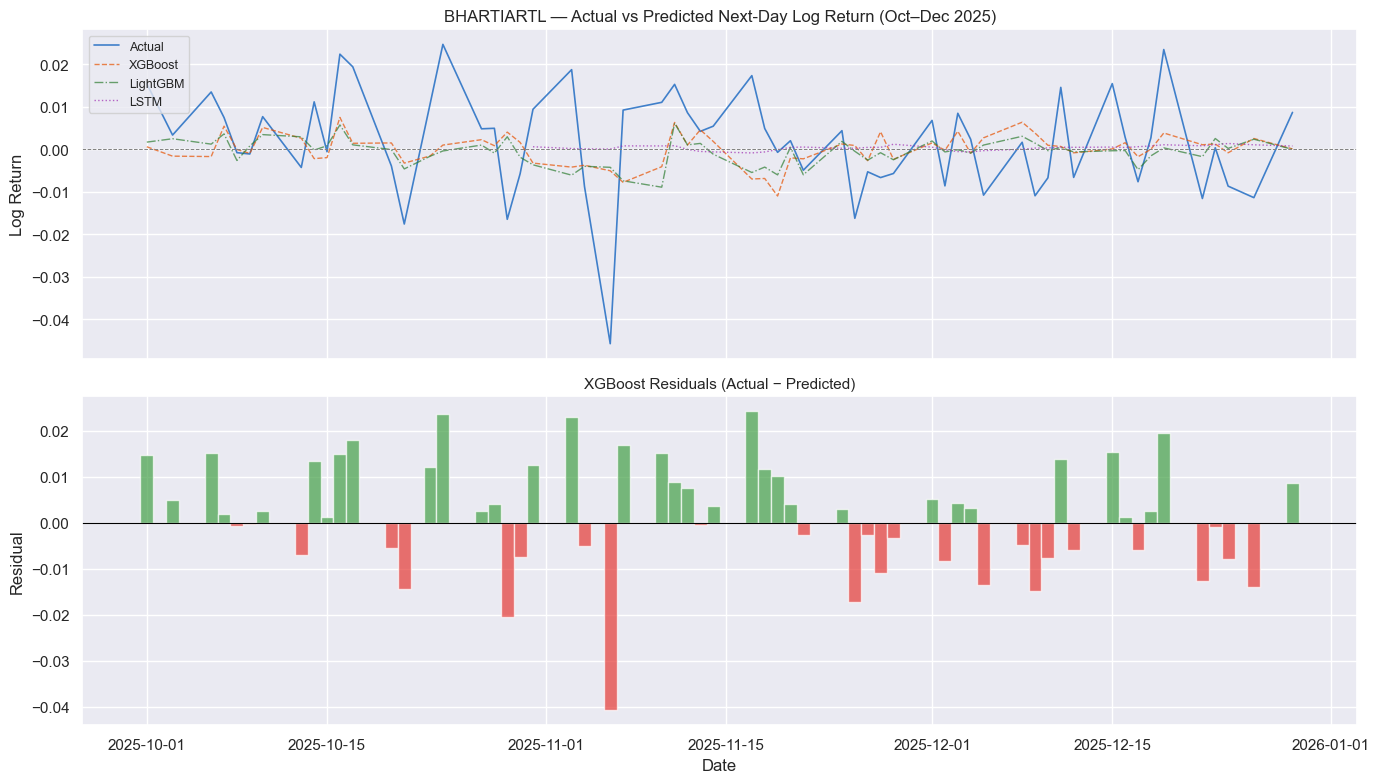

Saved → c:\Users\kiran\Desktop\IITM\Semester 4\DSAI for Finance\DA6701-Assignments\Assignment_2\visualizations\BHARTIARTL_actual_vs_predicted.png


In [20]:
# ============================================================
# VIZ 1: Actual vs Predicted (test period)
# ============================================================
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Use XGB for consistency (has same date alignment as actual)
actual_series = pd.Series(y_test, index=df_test['Date'])
xgb_series    = pd.Series(xgb_test_pred, index=df_test['Date'])
lgbm_series   = pd.Series(lgbm_test_pred, index=df_test['Date'])

# LSTM re-index (drops first LOOKBACK rows)
lstm_series = pd.Series(lstm_test_pred, index=pd.to_datetime(dates_aligned))

axes[0].plot(actual_series.index, actual_series.values,
             label='Actual', color='#1565C0', linewidth=1.2, alpha=0.8)
axes[0].plot(xgb_series.index, xgb_series.values,
             label='XGBoost', color='#E65100', linewidth=1, alpha=0.7, linestyle='--')
axes[0].plot(lgbm_series.index, lgbm_series.values,
             label='LightGBM', color='#2E7D32', linewidth=1, alpha=0.7, linestyle='-.')
axes[0].plot(lstm_series.index, lstm_series.values,
             label='LSTM', color='#9C27B0', linewidth=1, alpha=0.7, linestyle=':')
axes[0].axhline(0, color='gray', lw=0.7, linestyle='--')
axes[0].set_title(f'{STOCK} — Actual vs Predicted Next-Day Log Return (Oct–Dec 2025)', fontsize=12)
axes[0].legend(loc='upper left', fontsize=9)
axes[0].set_ylabel('Log Return')

# Residuals
residuals = actual_series - xgb_series
axes[1].bar(residuals.index, residuals.values,
            color=['#E53935' if r < 0 else '#43A047' for r in residuals],
            alpha=0.7, width=1)
axes[1].axhline(0, color='black', lw=0.8)
axes[1].set_title('XGBoost Residuals (Actual − Predicted)', fontsize=11)
axes[1].set_ylabel('Residual')
axes[1].set_xlabel('Date')

plt.tight_layout()
plt.savefig(VIZ_DIR / f'{STOCK}_actual_vs_predicted.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved → {VIZ_DIR / (STOCK + '_actual_vs_predicted.png')}")

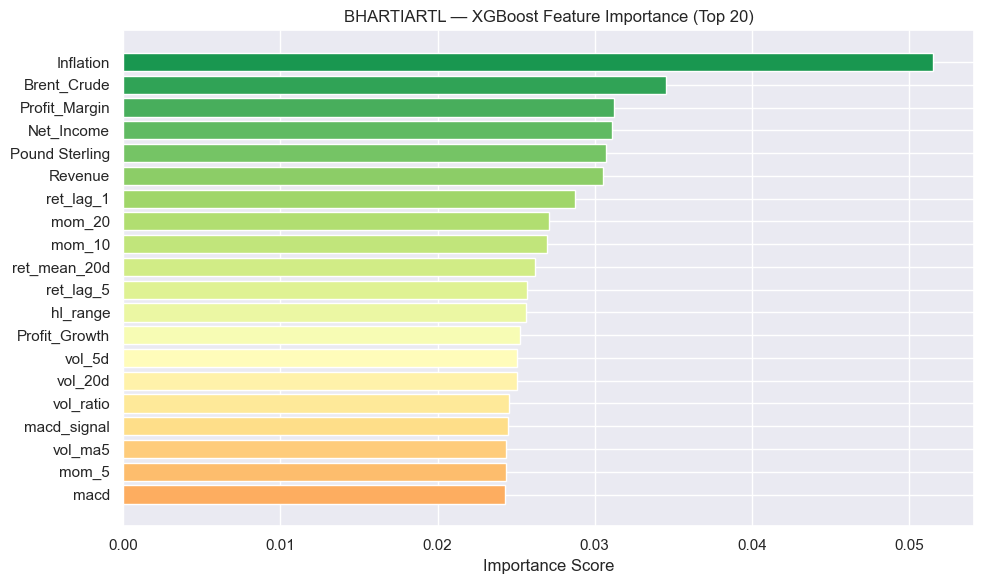

Saved → c:\Users\kiran\Desktop\IITM\Semester 4\DSAI for Finance\DA6701-Assignments\Assignment_2\visualizations\BHARTIARTL_feature_importance.png


In [21]:
# ============================================================
# VIZ 2: Feature Importance (XGBoost)
# ============================================================
feat_imp = pd.DataFrame({
    'Feature': FEATURE_COLS,
    'Importance': xgb_final.feature_importances_
}).sort_values('Importance', ascending=True)

top_n = min(20, len(feat_imp))
plot_df = feat_imp.tail(top_n)

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(plot_df['Feature'], plot_df['Importance'],
               color=plt.cm.RdYlGn(np.linspace(0.3, 0.9, top_n)))
ax.set_title(f'{STOCK} — XGBoost Feature Importance (Top {top_n})', fontsize=12)
ax.set_xlabel('Importance Score')
plt.tight_layout()
plt.savefig(VIZ_DIR / f'{STOCK}_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved → {VIZ_DIR / (STOCK + '_feature_importance.png')}")

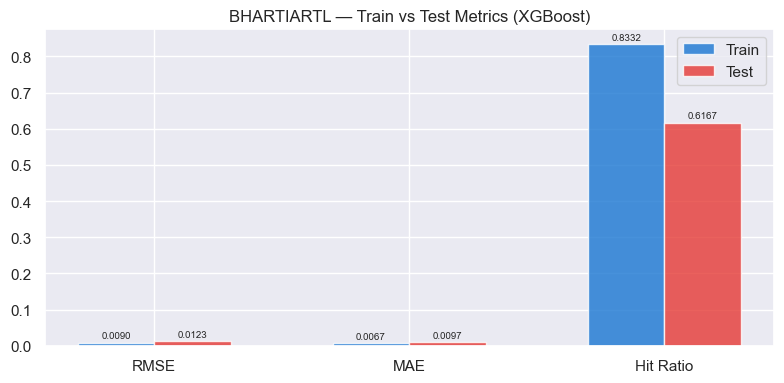

Overfitting check: gap between train/test hit ratio: 0.2165


In [22]:
# ============================================================
# VIZ 3: Train vs Test Error Comparison (Overfitting Check)
# ============================================================
train_pred_xgb = xgb_final.predict(X_train_sc)
train_m_xgb    = compute_metrics(y_train, train_pred_xgb)

fig, ax = plt.subplots(figsize=(8, 4))
metrics_names = ['rmse', 'mae', 'hit_ratio']
x = np.arange(len(metrics_names))
w = 0.3
bars_tr = ax.bar(x - w/2, [train_m_xgb[m] for m in metrics_names], w,
                 label='Train', color='#1976D2', alpha=0.8)
bars_te = ax.bar(x + w/2, [test_m_xgb[m] for m in metrics_names], w,
                 label='Test', color='#E53935', alpha=0.8)
ax.set_xticks(x)
ax.set_xticklabels(['RMSE', 'MAE', 'Hit Ratio'])
ax.set_title(f'{STOCK} — Train vs Test Metrics (XGBoost)', fontsize=12)
ax.legend()
ax.bar_label(bars_tr, fmt='%.4f', fontsize=7, padding=2)
ax.bar_label(bars_te, fmt='%.4f', fontsize=7, padding=2)
plt.tight_layout()
plt.savefig(VIZ_DIR / f'{STOCK}_train_vs_test.png', dpi=150, bbox_inches='tight')
plt.show()
print("Overfitting check: gap between train/test hit ratio:", round(train_m_xgb['hit_ratio'] - test_m_xgb['hit_ratio'], 4))

---
## Step 13 — Per-Stock Performance Summary

In [23]:
# ============================================================
# PER-STOCK METRICS SUMMARY
# ============================================================
print(f"\n{'='*60}")
print(f"  {STOCK} — FINAL PERFORMANCE REPORT")
print(f"{'='*60}")
print("\nWalk-Forward Validation (train period):")
for m, v in xgb_wf_mean.items():
    print(f"  XGB  {m:12s}: {v:.5f}")

print("\nTest Period (Oct–Dec 2025):")
for model, metrics in test_results.items():
    print(f"  {model.upper():6s} RMSE={metrics['rmse']:.5f}  MAE={metrics['mae']:.5f}  Hit={metrics['hit_ratio']:.3f}  Sharpe={metrics['sharpe']:.2f}")

print(f"\n  Best model (by WF-RMSE): {best_model_name.upper()}")
print(f"{'='*60}")


  BHARTIARTL — FINAL PERFORMANCE REPORT

Walk-Forward Validation (train period):
  XGB  rmse        : 0.01443
  XGB  mae         : 0.01074
  XGB  hit_ratio   : 0.52446
  XGB  sharpe      : 0.84252

Test Period (Oct–Dec 2025):
  XGB    RMSE=0.01258  MAE=0.00986  Hit=0.625  Sharpe=2.52
  LGBM   RMSE=0.01261  MAE=0.00966  Hit=0.600  Sharpe=2.49
  LSTM   RMSE=0.01220  MAE=0.00946  Hit=0.475  Sharpe=-1.34

  Best model (by WF-RMSE): LGBM


---
## Step 14 — Portfolio Construction (All 6 Stocks)

In [24]:
# ============================================================
# PORTFOLIO CONSTRUCTION
# Merges predictions from all 6 stocks and builds a portfolio
# ============================================================
ALL_STOCKS = ['RELIANCE', 'HDFCBANK', 'INFY', 'M&M', 'BHARTIARTL', 'HINDUNILVR']

pred_frames = []
available   = []

for s in ALL_STOCKS:
    p = PRED_DIR / f'{s}_predictions.csv'
    if p.exists():
        tmp = pd.read_csv(p, parse_dates=['Date'])
        tmp = tmp.rename(columns={'predicted_return': s})
        pred_frames.append(tmp.set_index('Date'))
        available.append(s)
    else:
        print(f"  [SKIP] {s} predictions not found yet")

if len(available) < 2:
    print("Need at least 2 stocks for portfolio construction. Run all notebooks first.")
else:
    # Merge on dates
    port_pred = pred_frames[0]
    for pf in pred_frames[1:]:
        port_pred = port_pred.join(pf, how='inner')

    port_pred = port_pred[available].dropna()
    print(f"Portfolio dates: {port_pred.index.min().date()} → {port_pred.index.max().date()}")
    print(f"Stocks included: {available}")

    # --- Risk-adjusted weights  (predicted_return / rolling_volatility) ---
    # Load actual returns for volatility estimation
    actual_returns = {}
    for s in available:
        dfr = pd.read_csv(DATA_DIR / f'{s}.csv', parse_dates=['Date'])
        dfr = dfr.sort_values('Date')
        dfr['log_return'] = np.log(dfr['close'] / dfr['close'].shift(1))
        # Historical vol (train period) per stock
        train_vol = dfr[dfr['Date'] <= TRAIN_END]['log_return'].std()
        actual_returns[s] = dfr.set_index('Date')['log_return']

    # Weights proportional to predicted_return / historical_vol  (clipped at 0 for long-only)
    hist_vols = np.array([actual_returns[s].std() for s in available])

    day_weights = {}
    for dt, row in port_pred.iterrows():
        pred_rets = row[available].values.astype(float)
        raw_w = pred_rets / (hist_vols + 1e-9)
        raw_w = np.clip(raw_w, 0, None)          # long-only
        total = raw_w.sum()
        if total < 1e-9:
            raw_w = np.ones(len(available)) / len(available)  # fallback equal weight
        else:
            raw_w /= total
        day_weights[dt] = dict(zip(available, raw_w))

    weights_df = pd.DataFrame(day_weights).T
    weights_df.index.name = 'Date'

    print("\nSample portfolio weights (first 5 days):")
    print(weights_df.head().round(4))

Portfolio dates: 2025-10-01 → 2025-12-29
Stocks included: ['RELIANCE', 'HDFCBANK', 'INFY', 'M&M', 'BHARTIARTL', 'HINDUNILVR']

Sample portfolio weights (first 5 days):
            RELIANCE  HDFCBANK    INFY     M&M  BHARTIARTL  HINDUNILVR
Date                                                                  
2025-10-01    0.1346    0.3518  0.0253  0.3847      0.1036      0.0000
2025-10-03    0.0340    0.2778  0.1370  0.3377      0.1539      0.0597
2025-10-06    0.0933    0.1314  0.2039  0.3679      0.0482      0.1553
2025-10-07    0.1997    0.1101  0.0471  0.1941      0.2481      0.2009
2025-10-08    0.0514    0.3198  0.3035  0.3253      0.0000      0.0000



Risk-Adjusted Portfolio:
  CAGR (ann):     74.48%
  Volatility:     10.70%
  Sharpe Ratio:   6.963
  Max Drawdown:   -2.32%

Equal-Weight Portfolio:
  CAGR (ann):     30.41%
  Volatility:     8.28%
  Sharpe Ratio:   3.671
  Max Drawdown:   -2.34%


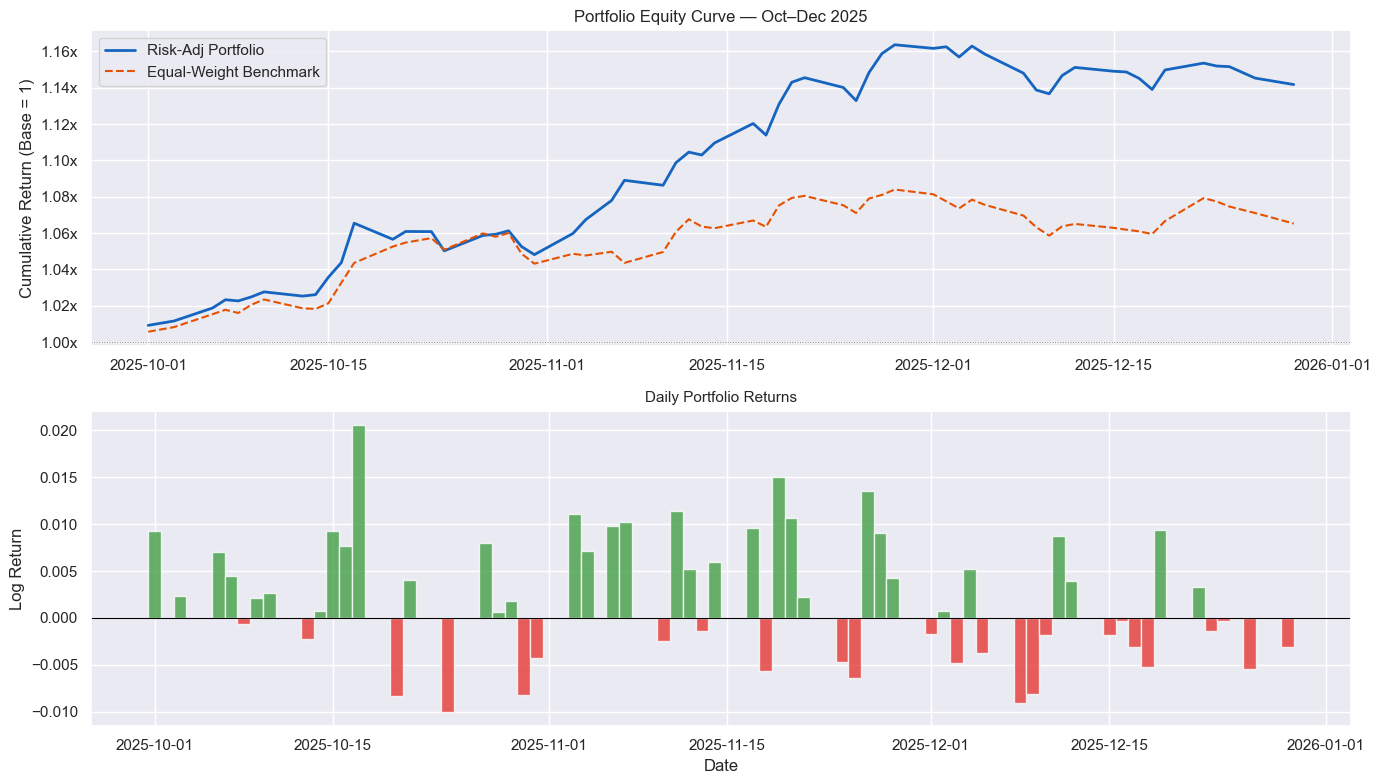

Saved → c:\Users\kiran\Desktop\IITM\Semester 4\DSAI for Finance\DA6701-Assignments\Assignment_2\visualizations\portfolio_equity_curve.png


In [25]:
# ============================================================
# PORTFOLIO BACKTEST (Oct–Dec 2025)
# ============================================================
if len(available) >= 2:
    # Actual daily log returns for each stock in the test window
    actual_ret_port = {}
    for s in available:
        dfr = pd.read_csv(DATA_DIR / f'{s}.csv', parse_dates=['Date'])
        dfr = dfr.sort_values('Date')
        dfr['log_return'] = np.log(dfr['close'] / dfr['close'].shift(1))
        test_mask = (dfr['Date'] >= TEST_START)
        actual_ret_port[s] = dfr[test_mask].set_index('Date')['log_return']

    actual_ret_df = pd.DataFrame(actual_ret_port).dropna()

    # Align weights to actual returns
    common_dates = weights_df.index.intersection(actual_ret_df.index)
    w_aligned    = weights_df.loc[common_dates, available]
    r_aligned    = actual_ret_df.loc[common_dates, available]

    # Daily portfolio return = sum(w_i * r_i)
    port_daily_ret = (w_aligned.values * r_aligned.values).sum(axis=1)
    port_dates     = common_dates

    # Cumulative equity curve
    equity = np.exp(np.cumsum(port_daily_ret))   # start at 1.0

    # Equal-weight benchmark
    eq_daily   = r_aligned.mean(axis=1)
    eq_equity  = np.exp(np.cumsum(eq_daily.values))

    # --- Performance Metrics ---
    def portfolio_metrics(daily_ret, label='Portfolio'):
        n_days = len(daily_ret)
        ann_ret  = np.exp(daily_ret.sum() * 252 / n_days) - 1
        ann_vol  = daily_ret.std() * np.sqrt(252)
        sharpe   = ann_ret / (ann_vol + 1e-9)
        cum      = np.exp(np.cumsum(daily_ret))
        roll_max = pd.Series(cum).cummax()
        mdd      = ((pd.Series(cum) - roll_max) / roll_max).min()
        cagr     = ann_ret
        print(f"\n{label}:")
        print(f"  CAGR (ann):     {cagr:.2%}")
        print(f"  Volatility:     {ann_vol:.2%}")
        print(f"  Sharpe Ratio:   {sharpe:.3f}")
        print(f"  Max Drawdown:   {mdd:.2%}")
        return {'CAGR': cagr, 'Volatility': ann_vol, 'Sharpe': sharpe, 'MaxDrawdown': mdd}

    port_metrics_out = portfolio_metrics(pd.Series(port_daily_ret), 'Risk-Adjusted Portfolio')
    eq_metrics_out   = portfolio_metrics(eq_daily, 'Equal-Weight Portfolio')

    # Plot equity curve
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))

    axes[0].plot(port_dates, equity, label='Risk-Adj Portfolio', color='#1565C0', lw=2)
    axes[0].plot(port_dates, eq_equity, label='Equal-Weight Benchmark', color='#E65100',
                 lw=1.5, linestyle='--')
    axes[0].axhline(1.0, color='gray', lw=0.7, linestyle=':')
    axes[0].set_title('Portfolio Equity Curve — Oct–Dec 2025', fontsize=12)
    axes[0].set_ylabel('Cumulative Return (Base = 1)')
    axes[0].legend()
    axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:.2f}x'))

    axes[1].bar(port_dates, port_daily_ret,
                color=['#43A047' if r > 0 else '#E53935' for r in port_daily_ret],
                alpha=0.8, width=1)
    axes[1].axhline(0, color='black', lw=0.8)
    axes[1].set_title('Daily Portfolio Returns', fontsize=11)
    axes[1].set_ylabel('Log Return')
    axes[1].set_xlabel('Date')

    plt.tight_layout()
    plt.savefig(VIZ_DIR / 'portfolio_equity_curve.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved → {VIZ_DIR / 'portfolio_equity_curve.png'}")

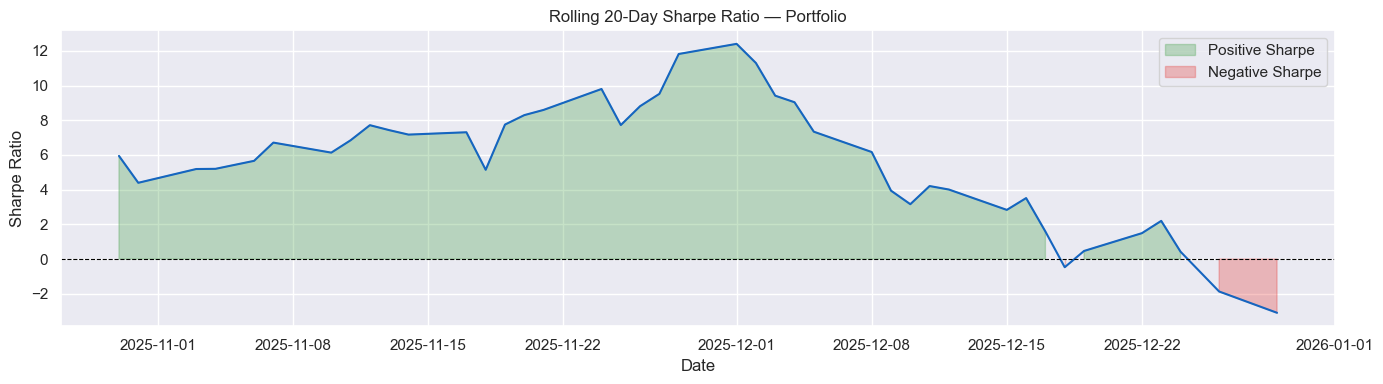

Saved → c:\Users\kiran\Desktop\IITM\Semester 4\DSAI for Finance\DA6701-Assignments\Assignment_2\visualizations\portfolio_rolling_sharpe.png


In [26]:
# ============================================================
# ROLLING SHARPE (30-day window)
# ============================================================
if len(available) >= 2:
    port_s = pd.Series(port_daily_ret, index=port_dates)
    rolling_sharpe = port_s.rolling(20).apply(
        lambda x: x.mean() / (x.std() + 1e-9) * np.sqrt(252), raw=True
    )

    fig, ax = plt.subplots(figsize=(14, 4))
    ax.plot(rolling_sharpe.index, rolling_sharpe.values, color='#1565C0', lw=1.5)
    ax.axhline(0, color='black', lw=0.8, linestyle='--')
    ax.fill_between(rolling_sharpe.index, rolling_sharpe.values,
                    where=(rolling_sharpe.values > 0), alpha=0.3, color='#43A047', label='Positive Sharpe')
    ax.fill_between(rolling_sharpe.index, rolling_sharpe.values,
                    where=(rolling_sharpe.values <= 0), alpha=0.3, color='#E53935', label='Negative Sharpe')
    ax.set_title('Rolling 20-Day Sharpe Ratio — Portfolio', fontsize=12)
    ax.set_ylabel('Sharpe Ratio')
    ax.set_xlabel('Date')
    ax.legend()
    plt.tight_layout()
    plt.savefig(VIZ_DIR / 'portfolio_rolling_sharpe.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved → {VIZ_DIR / 'portfolio_rolling_sharpe.png'}")

---
## Final Summary

In [27]:
# ============================================================
# FINAL SUMMARY
# ============================================================
print("\n" + "="*65)
print(f"  COMPLETE PIPELINE SUMMARY — {STOCK}")
print("="*65)
print(f"  Target          : Next-day log return")
print(f"  Train period    : Jan 2020 → Sep 2025")
print(f"  Test period     : Oct 2025 → Dec 2025")
print(f"  Walk-forward    : 5-fold expanding window")
print(f"  Models trained  : XGBoost, LightGBM, LSTM")
print(f"  Best model (WF) : {best_model_name.upper()}")
print()
print("  Walk-Forward Metrics (mean across folds):")
print(f"    XGB  → RMSE={results['xgb']['rmse']:.5f}  Hit={results['xgb']['hit_ratio']:.3f}  Sharpe={results['xgb']['sharpe']:.2f}")
print(f"    LGBM → RMSE={results['lgbm']['rmse']:.5f}  Hit={results['lgbm']['hit_ratio']:.3f}  Sharpe={results['lgbm']['sharpe']:.2f}")
print(f"    LSTM → RMSE={results['lstm']['rmse']:.5f}  Hit={results['lstm']['hit_ratio']:.3f}  Sharpe={results['lstm']['sharpe']:.2f}")
print()
print("  Outputs:")
print(f"    Predictions  → data/predicted/{STOCK}_predictions.csv")
print(f"    Visualizations:")
print(f"      - visualizations/{STOCK}_actual_vs_predicted.png")
print(f"      - visualizations/{STOCK}_feature_importance.png")
print(f"      - visualizations/{STOCK}_train_vs_test.png")
if len(available) >= 2:
    print(f"      - visualizations/portfolio_equity_curve.png")
    print(f"      - visualizations/portfolio_rolling_sharpe.png")
print("="*65)


  COMPLETE PIPELINE SUMMARY — BHARTIARTL
  Target          : Next-day log return
  Train period    : Jan 2020 → Sep 2025
  Test period     : Oct 2025 → Dec 2025
  Walk-forward    : 5-fold expanding window
  Models trained  : XGBoost, LightGBM, LSTM
  Best model (WF) : LGBM

  Walk-Forward Metrics (mean across folds):
    XGB  → RMSE=0.01443  Hit=0.524  Sharpe=0.84
    LGBM → RMSE=0.01420  Hit=0.524  Sharpe=0.98
    LSTM → RMSE=0.01978  Hit=0.490  Sharpe=-0.28

  Outputs:
    Predictions  → data/predicted/BHARTIARTL_predictions.csv
    Visualizations:
      - visualizations/BHARTIARTL_actual_vs_predicted.png
      - visualizations/BHARTIARTL_feature_importance.png
      - visualizations/BHARTIARTL_train_vs_test.png
      - visualizations/portfolio_equity_curve.png
      - visualizations/portfolio_rolling_sharpe.png
